# Graph Nets

Based on [DeepMind GraphNet example notebook](https://colab.research.google.com/github/deepmind/graph_nets/blob/master/graph_nets/demos/shortest_path.ipynb#scrollTo=tjd3-8PJdK2m).

## Preamble

In [1]:
import collections
import itertools
import time
import typing

from labm8 import humanize
from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf

from labm8 import labtypes
from labm8 import viz

from learn.daily.d181212_graph_nets_shortest_path import graph_util
from learn.daily.d181212_graph_nets_shortest_path import model

/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/learn/daily/d181212_graph_nets_shortest_path/notebooks/notebooks.runfiles/pypi__h5py_2_7_1/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Generating Random Graphs

**Undirected random graph**

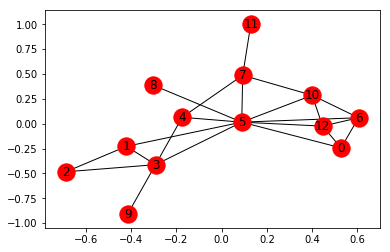

In [2]:
graph = graph_util.GenerateGraph(
    rand=np.random.RandomState(seed=1), 
    num_nodes_min_max=[10, 15], dimensions=2, theta=20, rate=1.0)

nx.draw_networkx(graph)

**Adding random shortest path labels**

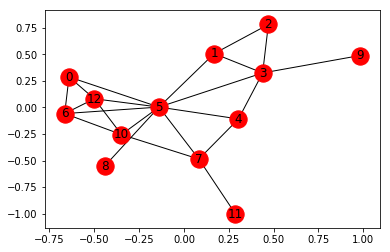

In [3]:
digraph = graph_util.AddShortestPath(np.random.RandomState(seed=1), graph)

nx.draw_networkx(graph)

**Preparing features**

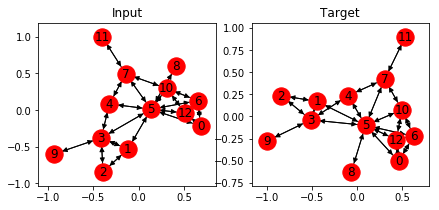

In [4]:
igraph, tgraph = graph_util.GraphToInputTarget(digraph)

fig = plt.figure(1, figsize=(7, 3))
fig.clf()

ax = fig.add_subplot(1, 2, 1)
ax.set_title('Input')
nx.draw_networkx(igraph, ax=ax)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Target')
nx.draw_networkx(tgraph, ax=ax)

### Random Seeds

In [5]:
SEED = 0xCEC
np.random.seed(SEED)
tf.set_random_seed(SEED)

## Helper functions

In [6]:
def create_placeholders(rand, batch_size, num_nodes_min_max, theta):
  """Creates placeholders for the model training and evaluation.

  Args:
    rand: A random seed (np.RandomState instance).
    batch_size: Total number of graphs per batch.
    num_nodes_min_max: A 2-tuple with the [lower, upper) number of nodes per
      graph. The number of nodes for a graph is uniformly sampled within this
      range.
    theta: A `float` threshold parameters for the geographic threshold graph's
      threshold. Default= the number of nodes.

  Returns:
    input_ph: The input graph's placeholders, as a graph namedtuple.
    target_ph: The target graph's placeholders, as a graph namedtuple.
  """
  # Create some example data for inspecting the vector sizes.
  input_graphs, target_graphs, _ = graph_util.GenerateGraphs(
      rand, batch_size, num_nodes_min_max, theta)
  input_ph = utils_tf.placeholders_from_networkxs(
      input_graphs, force_dynamic_num_graphs=True)
  target_ph = utils_tf.placeholders_from_networkxs(
      target_graphs, force_dynamic_num_graphs=True)
  return input_ph, target_ph


def create_feed_dict(rand, batch_size, num_nodes_min_max, theta, input_ph,
                     target_ph):
  """Creates placeholders for the model training and evaluation.

  Args:
    rand: A random seed (np.RandomState instance).
    batch_size: Total number of graphs per batch.
    num_nodes_min_max: A 2-tuple with the [lower, upper) number of nodes per
      graph. The number of nodes for a graph is uniformly sampled within this
      range.
    theta: A `float` threshold parameters for the geographic threshold graph's
      threshold. Default= the number of nodes.
    input_ph: The input graph's placeholders, as a graph namedtuple.
    target_ph: The target graph's placeholders, as a graph namedtuple.

  Returns:
    feed_dict: The feed `dict` of input and target placeholders and data.
    raw_graphs: The `dict` of raw networkx graphs.
  """
  inputs, targets, raw_graphs = graph_util.GenerateGraphs(
      rand, batch_size, num_nodes_min_max, theta)
  input_graphs = utils_np.networkxs_to_graphs_tuple(inputs)
  target_graphs = utils_np.networkxs_to_graphs_tuple(targets)
  feed_dict = {input_ph: input_graphs, target_ph: target_graphs}
  return feed_dict, raw_graphs


def compute_accuracy(target, output, use_nodes=True, use_edges=False):
  """Calculate model accuracy.

  Returns the number of correctly predicted shortest path nodes and the number
  of completely solved graphs (100% correct predictions).

  Args:
    target: A `graphs.GraphsTuple` that contains the target graph.
    output: A `graphs.GraphsTuple` that contains the output graph.
    use_nodes: A `bool` indicator of whether to compute node accuracy or not.
    use_edges: A `bool` indicator of whether to compute edge accuracy or not.

  Returns:
    correct: A `float` fraction of correctly labeled nodes/edges.
    solved: A `float` fraction of graphs that are completely correctly labeled.

  Raises:
    ValueError: Nodes or edges (or both) must be used
  """
  if not use_nodes and not use_edges:
    raise ValueError("Nodes or edges (or both) must be used")
  tdds = utils_np.graphs_tuple_to_data_dicts(target)
  odds = utils_np.graphs_tuple_to_data_dicts(output)
  cs = []
  ss = []
  for td, od in zip(tdds, odds):
    xn = np.argmax(td["nodes"], axis=-1)
    yn = np.argmax(od["nodes"], axis=-1)
    xe = np.argmax(td["edges"], axis=-1)
    ye = np.argmax(od["edges"], axis=-1)
    c = []
    if use_nodes:
      c.append(xn == yn)
    if use_edges:
      c.append(xe == ye)
    c = np.concatenate(c, axis=0)
    s = np.all(c)
    cs.append(c)
    ss.append(s)
  correct = np.mean(np.concatenate(cs, axis=0))
  solved = np.mean(np.stack(ss))
  return correct, solved

## Set up model training and evaluation

In [7]:
# The model we explore includes three components:
# - An "Encoder" graph net, which independently encodes the edge, node, and
#   global attributes (does not compute relations etc.).
# - A "Core" graph net, which performs N rounds of processing (message-passing)
#   steps. The input to the Core is the concatenation of the Encoder's output
#   and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
#   the processing step).
# - A "Decoder" graph net, which independently decodes the edge, node, and
#   global attributes (does not compute relations etc.), on each
#   message-passing step.
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
# The model is trained by supervised learning. Input graphs are procedurally
# generated, and output graphs have the same structure with the nodes and edges
# of the shortest path labeled (using 2-element 1-hot vectors). We could have
# predicted the shortest path only by labeling either the nodes or edges, and
# that does work, but we decided to predict both to demonstrate the flexibility
# of graph nets' outputs.
#
# The training loss is computed on the output of each processing step. The
# reason for this is to encourage the model to try to solve the problem in as
# few steps as possible. It also helps make the output of intermediate steps
# more interpretable.
#
# There's no need for a separate evaluate dataset because the inputs are
# never repeated, so the training loss is the measure of performance on graphs
# from the input distribution.
#
# We also evaluate how well the models generalize to graphs which are up to
# twice as large as those on which it was trained. The loss is computed only
# on the final processing step.
#
# Variables with the suffix _tr are training parameters, and variables with the
# suffix _ge are test/generalization parameters.
#
# After around 2000-5000 training iterations the model reaches near-perfect
# performance on graphs with between 8-16 nodes.

tf.reset_default_graph()

seed = 2
rand = np.random.RandomState(seed=seed)

# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 10
num_processing_steps_ge = 10

# Data / training parameters.
num_training_iterations = 10000
theta = 20  # Large values (1000+) make trees. Try 20-60 for good non-trees.
batch_size_tr = 32
batch_size_ge = 100
# Number of nodes per graph sampled uniformly from this range.
num_nodes_min_max_tr = (8, 17)
num_nodes_min_max_ge = (16, 33)

# Data.
# Input and target placeholders.
input_ph, target_ph = create_placeholders(rand, batch_size_tr,
                                          num_nodes_min_max_tr, theta)

# Connect the data to the model.
# Instantiate the model.
model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
# A list of outputs, one per processing step.
output_ops_tr = model(input_ph, num_processing_steps_tr)
output_ops_ge = model(input_ph, num_processing_steps_ge)

def create_loss_ops(target_op, output_ops):
  loss_ops = [
      tf.losses.softmax_cross_entropy(target_op.nodes, output_op.nodes) +
      tf.losses.softmax_cross_entropy(target_op.edges, output_op.edges)
      for output_op in output_ops
  ]
  return loss_ops

# Training loss.
loss_ops_tr = create_loss_ops(target_ph, output_ops_tr)
# Loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
# Test/generalization loss.
loss_ops_ge = create_loss_ops(target_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step.

# Optimizer.
learning_rate = 1e-3
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

def make_all_runnable_in_session(*args):
  """Lets an iterable of TF graphs be output from a session as NP graphs."""
  return [utils_tf.make_runnable_in_session(a) for a in args]

# Lets an iterable of TF graphs be output from a session as NP graphs.
input_ph, target_ph = make_all_runnable_in_session(input_ph, target_ph)

/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/learn/daily/d181212_graph_nets_shortest_path/notebooks/notebooks.runfiles/pypi__tensorflow_gpu_1_8_0/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Reset session

In [8]:
# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
  sess.close()
except NameError:
  pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []

## Run training

In [9]:
# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# How much time between logging and printing the current results.
log_every_seconds = 20

print(f'Beginning {humanize.Commas(num_training_iterations)} training iterations')
print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes/edges labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  feed_dict, _ = create_feed_dict(rand, batch_size_tr, num_nodes_min_max_tr,
                                  theta, input_ph, target_ph)
  train_values = sess.run({
      "step": step_op,
      "target": target_ph,
      "loss": loss_op_tr,
      "outputs": output_ops_tr
  },
                          feed_dict=feed_dict)
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    feed_dict, raw_graphs = create_feed_dict(
        rand, batch_size_ge, num_nodes_min_max_ge, theta, input_ph, target_ph)
    test_values = sess.run({
        "target": target_ph,
        "loss": loss_op_ge,
        "outputs": output_ops_ge
    },
                           feed_dict=feed_dict)
    correct_tr, solved_tr = compute_accuracy(
        train_values["target"], train_values["outputs"][-1], use_edges=True)
    correct_ge, solved_ge = compute_accuracy(
        test_values["target"], test_values["outputs"][-1], use_edges=True)
    elapsed = time.time() - start_time
    losses_tr.append(train_values["loss"])
    corrects_tr.append(correct_tr)
    solveds_tr.append(solved_tr)
    losses_ge.append(test_values["loss"])
    corrects_ge.append(correct_ge)
    solveds_ge.append(solved_ge)
    logged_iterations.append(iteration)
    print(f'# {humanize.Commas(iteration)}, T {humanize.Duration(elapsed)}, '
          f'Ltr {train_values["loss"]:.4f}, Lge {test_values["loss"]:.4f}, '
          f'Ctr {correct_tr:.4f}, Str {solved_tr:.4f}, '
          f'Cge {correct_ge:.4f}, Sge {solved_ge:.4f}')

Beginning 10,000 training iterations
# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction nodes/edges labeled correctly), Str (training fraction examples solved correctly), Cge (test/generalization fraction nodes/edges labeled correctly), Sge (test/generalization fraction examples solved correctly)
# 36, T 23 seconds, Ltr 0.8964, Lge 0.7081, Ctr 0.8513, Str 0.0000, Cge 0.9477, Sge 0.0000
# 92, T 42 seconds, Ltr 0.7939, Lge 0.5174, Ctr 0.8753, Str 0.0625, Cge 0.9601, Sge 0.0200
# 150, T a minute, Ltr 0.5441, Lge 0.4167, Ctr 0.9197, Str 0.0938, Cge 0.9662, Sge 0.2000
# 208, T a minute, Ltr 0.5632, Lge 0.3946, Ctr 0.9177, Str 0.0938, Cge 0.9653, Sge 0.1200
# 266, T a minute, Ltr 0.5896, Lge 0.3724, Ctr 0.8981, Str 0.1562, Cge 0.9666, Sge 0.1400
# 323, T 2 minutes, Ltr 0.4749, Lge 0.3684, Ctr 0.9269, Str 0.1250, Cge 0.9645, Sge 0.1700
# 379, T 2 minutes, Ltr 0.4332, Lge 0.3420, Ctr 0.9340, Str 0.2500, Cge 0.9684, Sge 0.1900


# 5,200, T 28 minutes, Ltr 0.1321, Lge 0.1007, Ctr 0.9934, Str 0.8750, Cge 0.9879, Sge 0.5700
# 5,258, T 28 minutes, Ltr 0.1449, Lge 0.1311, Ctr 0.9909, Str 0.8750, Cge 0.9847, Sge 0.5000
# 5,315, T 29 minutes, Ltr 0.1723, Lge 0.1041, Ctr 0.9882, Str 0.9062, Cge 0.9875, Sge 0.5500
# 5,374, T 29 minutes, Ltr 0.2580, Lge 0.1675, Ctr 0.9819, Str 0.7812, Cge 0.9794, Sge 0.4300
# 5,433, T 29 minutes, Ltr 0.1159, Lge 0.0934, Ctr 0.9981, Str 0.9688, Cge 0.9882, Sge 0.5800
# 5,491, T 30 minutes, Ltr 0.1600, Lge 0.1300, Ctr 0.9889, Str 0.8750, Cge 0.9833, Sge 0.4500
# 5,547, T 30 minutes, Ltr 0.1780, Lge 0.1036, Ctr 0.9912, Str 0.9062, Cge 0.9854, Sge 0.5200
# 5,603, T 30 minutes, Ltr 0.1473, Lge 0.1185, Ctr 0.9914, Str 0.8438, Cge 0.9863, Sge 0.5200
# 5,661, T 31 minutes, Ltr 0.1056, Lge 0.0885, Ctr 0.9974, Str 0.9062, Cge 0.9886, Sge 0.5800
# 5,717, T 31 minutes, Ltr 0.1304, Lge 0.0822, Ctr 1.0000, Str 1.0000, Cge 0.9887, Sge 0.6300
# 5,775, T 31 minutes, Ltr 0.1432, Lge 0.0865, Ctr 0.9934, S

## Visualize results

In [10]:
class GraphPlotter(object):

  def __init__(self, ax, graph, pos):
    self._ax = ax
    self._graph = graph
    self._pos = pos
    self._base_draw_kwargs = dict(G=self._graph, pos=self._pos, ax=self._ax)
    self._solution_length = None
    self._nodes = None
    self._edges = None
    self._start_nodes = None
    self._end_nodes = None
    self._solution_nodes = None
    self._intermediate_solution_nodes = None
    self._solution_edges = None
    self._non_solution_nodes = None
    self._non_solution_edges = None
    self._ax.set_axis_off()

  @property
  def solution_length(self):
    if self._solution_length is None:
      self._solution_length = len(self._solution_edges)
    return self._solution_length

  @property
  def nodes(self):
    if self._nodes is None:
      self._nodes = self._graph.nodes()
    return self._nodes

  @property
  def edges(self):
    if self._edges is None:
      self._edges = self._graph.edges()
    return self._edges

  @property
  def start_nodes(self):
    if self._start_nodes is None:
      self._start_nodes = [
          n for n in self.nodes if self._graph.node[n].get("start", False)
      ]
    return self._start_nodes

  @property
  def end_nodes(self):
    if self._end_nodes is None:
      self._end_nodes = [
          n for n in self.nodes if self._graph.node[n].get("end", False)
      ]
    return self._end_nodes

  @property
  def solution_nodes(self):
    if self._solution_nodes is None:
      self._solution_nodes = [
          n for n in self.nodes if self._graph.node[n].get("solution", False)
      ]
    return self._solution_nodes

  @property
  def intermediate_solution_nodes(self):
    if self._intermediate_solution_nodes is None:
      self._intermediate_solution_nodes = [
          n for n in self.nodes
          if self._graph.node[n].get("solution", False) and
          not self._graph.node[n].get("start", False) and
          not self._graph.node[n].get("end", False)
      ]
    return self._intermediate_solution_nodes

  @property
  def solution_edges(self):
    if self._solution_edges is None:
      self._solution_edges = [
          e for e in self.edges
          if self._graph.get_edge_data(e[0], e[1]).get("solution", False)
      ]
    return self._solution_edges

  @property
  def non_solution_nodes(self):
    if self._non_solution_nodes is None:
      self._non_solution_nodes = [
          n for n in self.nodes
          if not self._graph.node[n].get("solution", False)
      ]
    return self._non_solution_nodes

  @property
  def non_solution_edges(self):
    if self._non_solution_edges is None:
      self._non_solution_edges = [
          e for e in self.edges
          if not self._graph.get_edge_data(e[0], e[1]).get("solution", False)
      ]
    return self._non_solution_edges

  def _make_draw_kwargs(self, **kwargs):
    kwargs.update(self._base_draw_kwargs)
    return kwargs

  def _draw(self, draw_function, zorder=None, **kwargs):
    draw_kwargs = self._make_draw_kwargs(**kwargs)
    collection = draw_function(**draw_kwargs)
    if collection is not None and zorder is not None:
      try:
        # This is for compatibility with older matplotlib.
        collection.set_zorder(zorder)
      except AttributeError:
        # This is for compatibility with newer matplotlib.
        collection[0].set_zorder(zorder)
    return collection

  def draw_nodes(self, **kwargs):
    """Useful kwargs: nodelist, node_size, node_color, linewidths."""
    if ("node_color" in kwargs and
        isinstance(kwargs["node_color"], collections.Sequence) and
        len(kwargs["node_color"]) in {3, 4} and
        not isinstance(kwargs["node_color"][0],
                       (collections.Sequence, np.ndarray))):
      num_nodes = len(kwargs.get("nodelist", self.nodes))
      kwargs["node_color"] = np.tile(
          np.array(kwargs["node_color"])[None], [num_nodes, 1])
    return self._draw(nx.draw_networkx_nodes, **kwargs)

  def draw_edges(self, **kwargs):
    """Useful kwargs: edgelist, width."""
    return self._draw(nx.draw_networkx_edges, **kwargs)

  def draw_graph(self,
                 node_size=200,
                 node_color=(0.4, 0.8, 0.4),
                 node_linewidth=1.0,
                 edge_width=1.0):
    # Plot nodes.
    self.draw_nodes(
        nodelist=self.nodes,
        node_size=node_size,
        node_color=node_color,
        linewidths=node_linewidth,
        zorder=20)
    # Plot edges.
    self.draw_edges(edgelist=self.edges, width=edge_width, zorder=10)

  def draw_graph_with_solution(self,
                               node_size=200,
                               node_color=(0.4, 0.8, 0.4),
                               node_linewidth=1.0,
                               edge_width=1.0,
                               start_color="w",
                               end_color="k",
                               solution_node_linewidth=3.0,
                               solution_edge_width=3.0):
    node_border_color = (0.0, 0.0, 0.0, 1.0)
    node_collections = {}
    # Plot start nodes.
    node_collections["start nodes"] = self.draw_nodes(
        nodelist=self.start_nodes,
        node_size=node_size,
        node_color=start_color,
        linewidths=solution_node_linewidth,
        edgecolors=node_border_color,
        zorder=100)
    # Plot end nodes.
    node_collections["end nodes"] = self.draw_nodes(
        nodelist=self.end_nodes,
        node_size=node_size,
        node_color=end_color,
        linewidths=solution_node_linewidth,
        edgecolors=node_border_color,
        zorder=90)
    # Plot intermediate solution nodes.
    if isinstance(node_color, dict):
      c = [node_color[n] for n in self.intermediate_solution_nodes]
    else:
      c = node_color
    node_collections["intermediate solution nodes"] = self.draw_nodes(
        nodelist=self.intermediate_solution_nodes,
        node_size=node_size,
        node_color=c,
        linewidths=solution_node_linewidth,
        edgecolors=node_border_color,
        zorder=80)
    # Plot solution edges.
    node_collections["solution edges"] = self.draw_edges(
        edgelist=self.solution_edges, width=solution_edge_width, zorder=70)
    # Plot non-solution nodes.
    if isinstance(node_color, dict):
      c = [node_color[n] for n in self.non_solution_nodes]
    else:
      c = node_color
    node_collections["non-solution nodes"] = self.draw_nodes(
        nodelist=self.non_solution_nodes,
        node_size=node_size,
        node_color=c,
        linewidths=node_linewidth,
        edgecolors=node_border_color,
        zorder=20)
    # Plot non-solution edges.
    node_collections["non-solution edges"] = self.draw_edges(
        edgelist=self.non_solution_edges, width=edge_width, zorder=10)
    # Set title as solution length.
    self._ax.set_title("Solution length: {}".format(self.solution_length))
    return node_collections

def softmax_prob_last_dim(x):  # pylint: disable=redefined-outer-name
  e = np.exp(x)
  return e[:, -1] / np.sum(e, axis=-1)

def get_node_dict(graph, attr):
  """Return a `dict` of node:attribute pairs from a graph."""
  return {k: v[attr] for k, v in graph.node.items()}

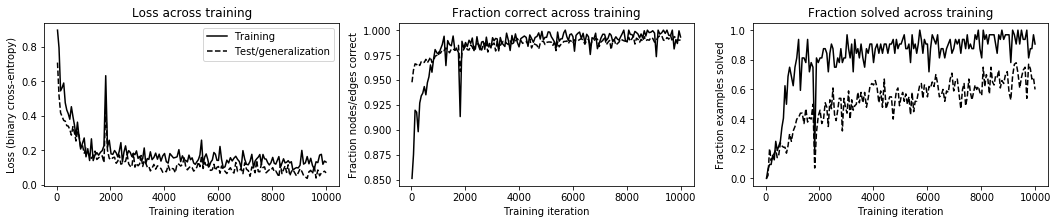

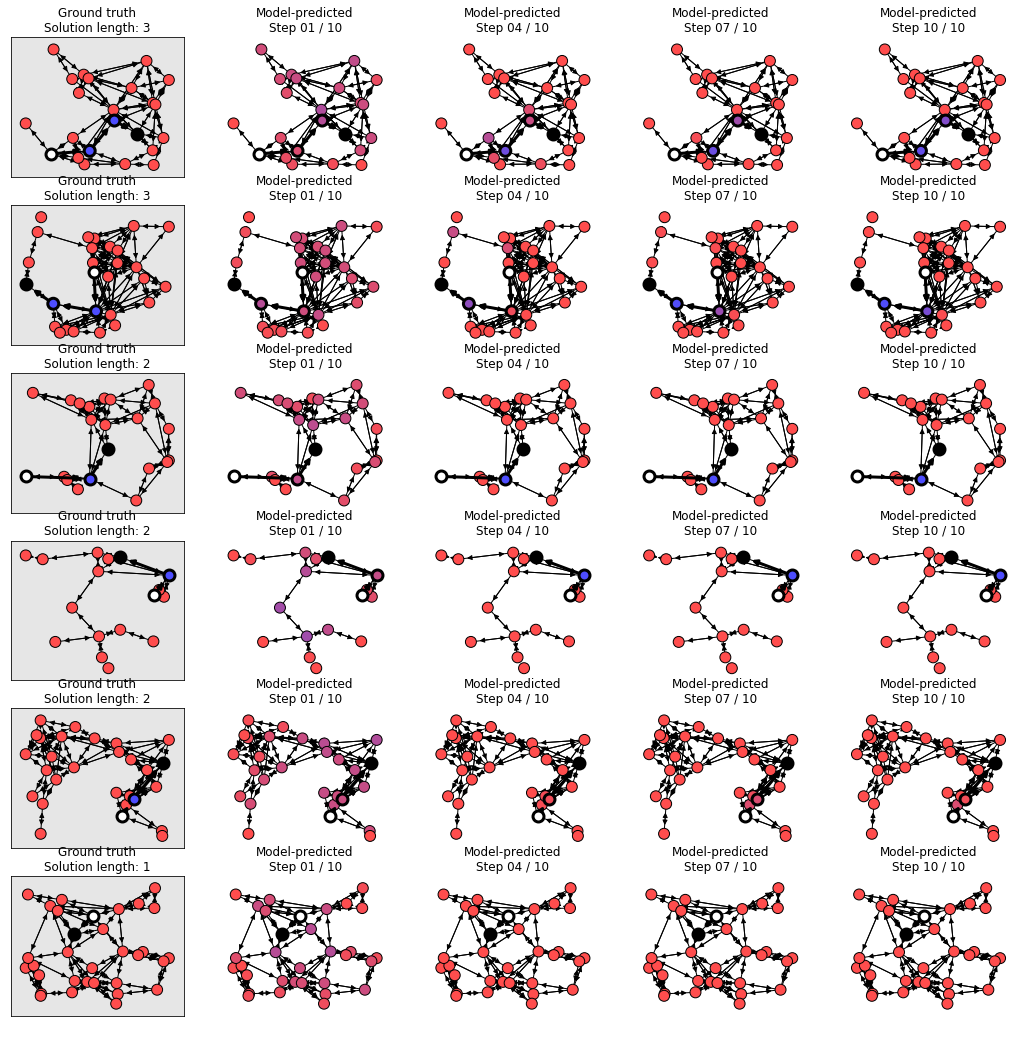

In [11]:
# This cell visualizes the results of training. You can visualize the
# intermediate results by interrupting execution of the cell above, and running
# this cell. You can then resume training by simply executing the above cell
# again.

# Plot results curves.
fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Loss.
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (binary cross-entropy)")
ax.legend()
# Correct.
y_tr = corrects_tr
y_ge = corrects_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction correct across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction nodes/edges correct")
# Solved.
y_tr = solveds_tr
y_ge = solveds_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction solved across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction examples solved")

# Plot graphs and results after each processing step.
# The white node is the start, and the black is the end. Other nodes are colored
# from red to purple to blue, where red means the model is confident the node is
# off the shortest path, blue means the model is confident the node is on the
# shortest path, and purplish colors mean the model isn't sure.
max_graphs_to_plot = 6
num_steps_to_plot = 4
node_size = 120
min_c = 0.3
num_graphs = len(raw_graphs)
targets = utils_np.graphs_tuple_to_data_dicts(test_values["target"])
step_indices = np.floor(
    np.linspace(0, num_processing_steps_ge - 1,
                num_steps_to_plot)).astype(int).tolist()
outputs = list(
    zip(*(utils_np.graphs_tuple_to_data_dicts(test_values["outputs"][i])
          for i in step_indices)))
h = min(num_graphs, max_graphs_to_plot)
w = num_steps_to_plot + 1
fig = plt.figure(101, figsize=(18, h * 3))
fig.clf()
ncs = []
for j, (graph, target, output) in enumerate(zip(raw_graphs, targets, outputs)):
  if j >= h:
    break
  pos = get_node_dict(graph, "pos")
  ground_truth = target["nodes"][:, -1]
  # Ground truth.
  iax = j * (1 + num_steps_to_plot) + 1
  ax = fig.add_subplot(h, w, iax)
  plotter = GraphPlotter(ax, graph, pos)
  color = {}
  for i, n in enumerate(plotter.nodes):
    color[n] = np.array([1.0 - ground_truth[i], 0.0, ground_truth[i], 1.0
                        ]) * (1.0 - min_c) + min_c
  plotter.draw_graph_with_solution(node_size=node_size, node_color=color)
  ax.set_axis_on()
  ax.set_xticks([])
  ax.set_yticks([])
  try:
    ax.set_facecolor([0.9] * 3 + [1.0])
  except AttributeError:
    ax.set_axis_bgcolor([0.9] * 3 + [1.0])
  ax.grid(None)
  ax.set_title("Ground truth\nSolution length: {}".format(
      plotter.solution_length))
  # Prediction.
  for k, outp in enumerate(output):
    iax = j * (1 + num_steps_to_plot) + 2 + k
    ax = fig.add_subplot(h, w, iax)
    plotter = GraphPlotter(ax, graph, pos)
    color = {}
    prob = softmax_prob_last_dim(outp["nodes"])
    for i, n in enumerate(plotter.nodes):
      color[n] = np.array([1.0 - prob[n], 0.0, prob[n], 1.0
                          ]) * (1.0 - min_c) + min_c
    plotter.draw_graph_with_solution(node_size=node_size, node_color=color)
    ax.set_title("Model-predicted\nStep {:02d} / {:02d}".format(
        step_indices[k] + 1, step_indices[-1] + 1))

End of notebook.